In [1]:
import csv
import re
import pandas as pd
#None para visualizar todas las columnas, False para la version recortada
pd.set_option("display.max_columns", None)


#Parseo de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/Mineria/'
filename = "dataset_pln_20211019.csv"

Se parsean los datos manualmente y no con pandas,
porque es mas facil para agregar las cantidades de respuestas de cada tuit

In [3]:
is_first_cell = True
tweets_dicc = {}

with open(drive_path+filename, mode='r') as csv_file:
  csv_reader = csv.DictReader(csv_file)
  for row in csv_reader:
    if is_first_cell:
      print(f'Column names are {", ".join(row)}')
      is_first_cell = False

    id_str = row["id_str"]
    in_reply_to_status_id = row["in_reply_to_status_id"]
    full_text = row["full_text"]
    
    created_at = row["created_at"]
    in_reply_to_user_id = row["in_reply_to_user_id"]
    user_id = row["user_id"]

    # Eliminar hashtags, menciones y urls
    full_text = re.sub('#\w+ ', '', full_text)
    full_text = re.sub('@\w+ ', '', full_text)
    full_text = re.sub(r'http\S+', '', full_text)
    row["full_text"] =full_text


    # Contar las respuestas y ponerlo en una nueva columna
    # si ya existe un tweet de ese id, es porque se creo, porque tenia una respuesta
    if tweets_dicc.get(id_str):
      tweets_dicc[id_str].update(row)
    # si es la primera vez que lo vimos, creamos el dict por completo
    else:
      tweets_dicc[id_str] = {**{"ans": 0}, **row }

    #si es respuesta de x
    if in_reply_to_status_id:
      #si es la primera respuesta que recibe x
      if not tweets_dicc.get(in_reply_to_status_id,{}).get("ans",0):
        #si todavia no vimos a x
        if not tweets_dicc.get(in_reply_to_status_id, {}).get("id_str"):
          tweets_dicc[in_reply_to_status_id] = {"ans": 1}
        #si ya vimos a x
        else:
          tweets_dicc[in_reply_to_status_id].update({"ans": 1})
      #si x ya tuvo otra respuesta
      else:
        tweets_dicc[in_reply_to_status_id]["ans"] +=1

Column names are created_at, id_str, full_text, in_reply_to_status_id, in_reply_to_user_id, user_id


In [4]:
#Borrar los tuits que no tienen texto en la bd
#i y j son para contar la cantidad de tuits que hay con y sin texto
dic_ans_num = {}
tw_wo_text = []
# i = 0
# j = 0
for tw_id in tweets_dicc:
  # print(tweets_dicc[tw_id].get("id_str"), tweets_dicc[tw_id].get("ans"))
  # j+=1
  id = tweets_dicc[tw_id].get("id_str")
  ans = tweets_dicc[tw_id].get("ans")
  dic_ans_num[ans] = dic_ans_num.get(ans,0)+1
  
  #hay i (358) tweets de 163441 que tienen respuesta, pero no tienen texto en la bd
  if not id :
    tw_wo_text.append(tw_id)
    # i +=1
    # print(id, tw_id, ans)

# print(len(tweets_dicc))
#borrando del dicc los tw sin texo
for id in tw_wo_text:
  del tweets_dicc[id]
# print(i, j, j-i)
# print(len(tweets_dicc))


Hacemos un arreglo donde cada indice representa la cantidad de respuestas de un tuit, para contar cuantos tuits tienen cuantas respuestas. Con 20 como limite ya que considero que a partir de ese punto no hay una gran diferencia.

In [6]:
n_arr = []
ans_arr = [0]*21
for tw_id in tweets_dicc:
  ans = tweets_dicc[tw_id].get("ans")
  n_arr.append(ans)
  if ans <= 20:
    ans_arr[ans]+=1
  else:
    ans_arr[20]+=1


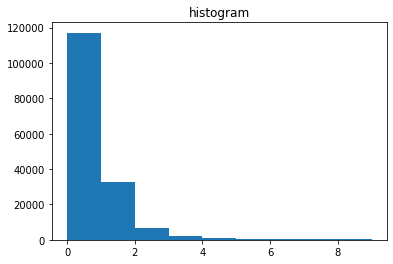

In [7]:
from matplotlib import pyplot as plt 
import numpy as np  
   
plt.hist(n_arr, bins = range(10)) 
plt.title("histogram") 
plt.show()

Vemos cuantos tuits tienen cuantas respuestas, y hacemos una aproximacion de como deberian dividirse las clases. Vemos que conviene dividir en 0, 1, 2 y mas de 2. Pero necesitamos dividir las clases del 0 y 1 en subgrupos.

In [8]:
ans_class_arr = []
classes_arr = []
max = 6000 #elegi dividir asi para tenerla lo mas balanceado posible
sum = 0
for i, elem in enumerate(ans_arr):
  sum +=elem
  if sum>= max:
    classes_arr.append(i)
    ans_class_arr.append(sum)
    sum = 0

print(ans_class_arr, classes_arr)
for i, ans in enumerate(ans_arr):
  print (i, ans)

[117094, 32487, 6482, 7020] [0, 1, 2, 20]
0 117094
1 32487
2 6482
3 2174
4 1043
5 586
6 414
7 318
8 232
9 170
10 157
11 149
12 138
13 104
14 102
15 99
16 72
17 70
18 58
19 63
20 1071


In [9]:
#Agregar los tags a los tuits segun su cantidad de respuestas
#hacer un histogramaa para cada cantidad
dic_ans_class = {"0":0,
                 "1":0,
                 "2":0,
                 "3+":0}

for tw_id in tweets_dicc:
  ans = tweets_dicc[tw_id].get("ans")
  if ans ==0:
    dic_ans_class["0"]+=1
    tweets_dicc[tw_id]["class"] = "0" #dividir en 20 clases
  elif ans ==1:
    dic_ans_class["1"]+=1
    tweets_dicc[tw_id]["class"] = "1" #dividir en 5 clases
  elif ans ==2:
    dic_ans_class["2"]+=1
    tweets_dicc[tw_id]["class"] = "2"
  else:
    dic_ans_class["3+"]+=1
    tweets_dicc[tw_id]["class"] = "+3"


In [10]:
print(dic_ans_class)

{'0': 117094, '1': 32487, '2': 6482, '3+': 7020}


Vemos que las clases del 0 y 1 estan bastante desbalanceadas

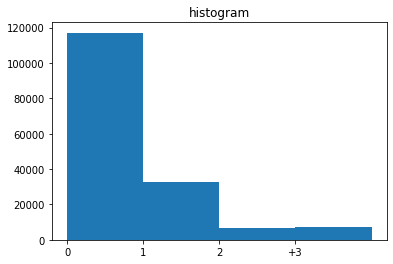

In [11]:
new_n_arr = ["0","1","2","+3"]
for tw_id in tweets_dicc:
  ans = tweets_dicc[tw_id].get("class")
  new_n_arr.append(ans)
   
plt.hist(new_n_arr, bins = [0,1,2,3,4]) 
plt.title("histogram") 
plt.show()

Asi va a quedar cuando se dividan las clases del 0 y del 1

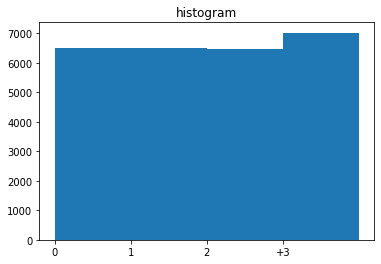

In [12]:
n_arr_class_2 = ["0","1","2","+3"]
to_tw = 0
to_fiv = 0
for tw_id in tweets_dicc:
  ans = tweets_dicc[tw_id].get("class")
  if ans == "0":
    to_tw = (to_tw + 1)%18
    if not to_tw:
      n_arr_class_2.append(ans)
  elif ans == "1":
    to_fiv = (to_fiv + 1)%5
    if not to_fiv:
      n_arr_class_2.append(ans)
  else:
    n_arr_class_2.append(ans)
   
plt.hist(n_arr_class_2, bins = [0,1,2,3,4]) 
plt.title("histogram") 
plt.show()

In [13]:
#paso los tuits a un dataframe para dividirlo mas facilmente
tweets_df = pd.DataFrame.from_dict(tweets_dicc, orient='index')
# print(tweets_df)

In [14]:
#Dividir el df en 80 10 10
#training_df tiene el 80%
training_df = tweets_df.sample(frac = 0.80)
#rest tiene el 20%
rest = tweets_df.drop(training_df.index)

#develop tiene el 10% (50% del 20% de rest)
develop_df = rest.sample(frac = 0.50) 

#test tiene el 10% (50% del 20% de rest)
test_df =  rest.drop(develop_df.index)

# print(len(training_df), len(develop_df), len(test_df))
# print(len(training_df)+ len(develop_df)+ len(test_df))

In [15]:
training_df

,ans,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user_id,class
1356632842562854912,0,Tue Feb 02 15:57:29 +0000 2021,1356632842562854912,"Preferiste el de lineker Sandra, no mientas",1356600708347420673,252168075,2541688542,0
1364057275053260801,0,Tue Feb 23 03:39:31 +0000 2021,1364057275053260801,MALDITO PERONISMO ✌️💩✌️💩✌️💩......................,1363978312008278016,252168075,2755839968,0
1370288260082188288,1,Fri Mar 12 08:19:14 +0000 2021,1370288260082188288,No vi el programa ¿Qué hacen con esos niños?.,1370186723121115143,931564592328781824,1142147723501690880,1
1366951069679517702,0,Wed Mar 03 03:18:26 +0000 2021,1366951069679517702,Coincido contigo Sandra.,1366932109659693057,252168075,1362610943356784641,0
1373099939283226624,0,Sat Mar 20 02:31:51 +0000 2021,1373099939283226624,Con tal que no empiecen a prender fuego en las...,1373097282611056640,1190413307183869954,203769304,0
...,...,...,...,...,...,...,...,...
1370370019130019847,1,Fri Mar 12 13:44:07 +0000 2021,1370370019130019847,Gracias Ernesto! un abrazo Grande!,1370178231668719616,73102744,312708081,1
1367592545128124419,1,Thu Mar 04 21:47:26 +0000 2021,1367592545128124419,"""Los que se vacunaron y tuvieron la enfermedad...",,,135371236,1
1368264581924143104,0,Sat Mar 06 18:17:52 +0000 2021,1368264581924143104,"Primero que es mentira y sobra información, y ...",1368004477320638465,191963043,320521829,0
1372147050649903106,0,Wed Mar 17 11:25:24 +0000 2021,1372147050649903106,que pida un amparo o le tiemblan las piernas?,1372142729623375876,252168075,1315037650982768642,0


In [16]:
training_0_df  = training_df.loc[training_df['class'] == "0"]
training_1_df  = training_df.loc[training_df['class'] == "1"]

# training_2_df  = training_df.loc[training_df['class'] == "2"]
# training_3_df  = training_df.loc[training_df['class'] == "+3"]
#extra tiene las clases de 2 y +3, los df de esas clases no hacen falta
training_extra_df = training_df.drop(training_0_df.index)
training_extra_df = training_extra_df.drop(training_1_df.index)

In [ ]:
training_0_df['subgrupo'] = np.random.randint(1,19, size=len(training_0_df))#93781 / 5400  (5400 es el promedio entre las otras clases, da 18 )
training_1_df['subgrupo'] = np.random.randint(1,6, size=len(training_1_df))#25895/5400 da 5
training_extra_df['subgrupo'] = np.zeros(shape=len(training_extra_df), dtype = int)

Aqui podemos ver finalmente como quedaron divididos en cantidades luego de la division en subgrupos. En verde estan las clases de 2 y +3, en naranja los subgrupos de 1 y en azul los subgrupos de 0.

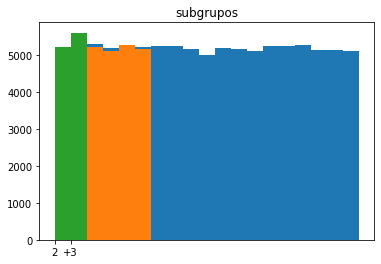

In [18]:

arreglo_0 = training_0_df[['subgrupo']].to_numpy()
arreglo_1 = training_1_df[['subgrupo']].to_numpy()
arreglo_extra = arregloo = training_extra_df[['class']].to_numpy()
plt.hist(arreglo_0, bins = range(1,20)) 
plt.hist(arreglo_1, bins = range(1,7)) 
plt.hist(arreglo_extra, bins = [0,1,2]) 

plt.title("subgrupos") 
plt.show()


Vemos como quedan finalmente los dataframes, con las columnas de ans (cantidad de respuestas), class y subgrupo

In [19]:
training_extra_df

,ans,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user_id,class,subgrupo
1345386062949085185,2,Sat Jan 02 15:06:48 +0000 2021,1345386062949085185,Sandra tengo una duda. Si tenes anticuerpos pa...,1345309823659888642,252168075,60205648,2,0
1368011754412904448,2,Sat Mar 06 01:33:13 +0000 2021,1368011754412904448,Chile está dando masivamente una vacuna (la Si...,1368011348177788933,1363365006637686784,2687724840,2,0
1346207409920946176,5,Mon Jan 04 21:30:32 +0000 2021,1346207409920946176,"Por eso, ahora me voy a divertir con ustedes. ...",1346207178487705606,252168075,252168075,+3,0
1365280222837432323,3,Fri Feb 26 12:39:05 +0000 2021,1365280222837432323,"yo, sin ser experta, solo usando el sentido co...",1365258052073578499,46187098,1161331415675559936,+3,0
1359719693494411264,4,Thu Feb 11 04:23:31 +0000 2021,1359719693494411264,Lo cual demuestra que no es necesario hacer ci...,1359667090282713090,73102744,1227443894750777346,+3,0
...,...,...,...,...,...,...,...,...,...
1346274751019446272,2,Tue Jan 05 01:58:07 +0000 2021,1346274751019446272,"Los naranju eran, al igual q mielcitas, de suc...",1346269166907641856,593189095,167098309,2,0
1363846320398749697,2,Mon Feb 22 13:41:16 +0000 2021,1363846320398749697,"No, no es así, las F3 comenzaron en Perú, Emir...",1363845267003494401,3354940761,1255121363481825281,2,0
1370062445352456197,2,Thu Mar 11 17:21:56 +0000 2021,1370062445352456197,Le pido la renuncia por hijo de mil putas que ...,1370024319678509059,194853341,79840600,2,0
1369462781175607296,2,Wed Mar 10 01:39:05 +0000 2021,1369462781175607296,"Pero solo renuncian los nuestros, los de ellos...",,,2687724840,2,0


In [20]:
training_0_df

,ans,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user_id,class,subgrupo
1356632842562854912,0,Tue Feb 02 15:57:29 +0000 2021,1356632842562854912,"Preferiste el de lineker Sandra, no mientas",1356600708347420673,252168075,2541688542,0,10
1364057275053260801,0,Tue Feb 23 03:39:31 +0000 2021,1364057275053260801,MALDITO PERONISMO ✌️💩✌️💩✌️💩......................,1363978312008278016,252168075,2755839968,0,10
1366951069679517702,0,Wed Mar 03 03:18:26 +0000 2021,1366951069679517702,Coincido contigo Sandra.,1366932109659693057,252168075,1362610943356784641,0,2
1373099939283226624,0,Sat Mar 20 02:31:51 +0000 2021,1373099939283226624,Con tal que no empiecen a prender fuego en las...,1373097282611056640,1190413307183869954,203769304,0,2
1369017262053732356,0,Mon Mar 08 20:08:45 +0000 2021,1369017262053732356,y los neutralizantes dieron menos todavía. tod...,1369011934515900422,252168075,1368752578939457536,0,8
...,...,...,...,...,...,...,...,...,...
1356314605119795201,0,Mon Feb 01 18:52:55 +0000 2021,1356314605119795201,Habría que vacunar los jueces y a estos embust...,1356256145145548802,252168075,86040685,0,5
1364193738063503361,0,Tue Feb 23 12:41:47 +0000 2021,1364193738063503361,"Que se puede esperar, de los que saltaban por ...",1364188047940739076,252168075,1224752003429150727,0,8
1368264581924143104,0,Sat Mar 06 18:17:52 +0000 2021,1368264581924143104,"Primero que es mentira y sobra información, y ...",1368004477320638465,191963043,320521829,0,10
1372147050649903106,0,Wed Mar 17 11:25:24 +0000 2021,1372147050649903106,que pida un amparo o le tiemblan las piernas?,1372142729623375876,252168075,1315037650982768642,0,16


In [21]:
training_1_df

,ans,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user_id,class,subgrupo
1370288260082188288,1,Fri Mar 12 08:19:14 +0000 2021,1370288260082188288,No vi el programa ¿Qué hacen con esos niños?.,1370186723121115143,931564592328781824,1142147723501690880,1,4
1369460551173148676,1,Wed Mar 10 01:30:13 +0000 2021,1369460551173148676,No me deja abrir el enlace,1369374156966555648,367933714,721283184017715200,1,4
1367440463574269957,1,Thu Mar 04 11:43:06 +0000 2021,1367440463574269957,Mi mamá de 79 años todavía no tiene turno... g...,1367290909528903682,1174969916,227803561,1,2
1361802735339896832,1,Tue Feb 16 22:20:47 +0000 2021,1361802735339896832,NORA hoy es 16 de febrero,1361777731978067975,130979339,2894716515,1,4
1355388511923408896,1,Sat Jan 30 05:32:57 +0000 2021,1355388511923408896,Mononeurales. Repiten los relatos que les crea...,1355236329303453706,1188178169062416385,2880225617,1,5
...,...,...,...,...,...,...,...,...,...
1372949806306504713,1,Fri Mar 19 16:35:16 +0000 2021,1372949806306504713,Ya que tengas que elegir comparar a la Argenti...,1372925750131757063,60909246,538105105,1,1
1360739293837332488,1,Sat Feb 13 23:55:03 +0000 2021,1360739293837332488,"Pero la libertad y coso, no? Nos merecemos lo ...",1360738595280220160,593189095,833671850,1,1
1349688804412690432,1,Thu Jan 14 12:04:21 +0000 2021,1349688804412690432,"Entonces aquí, antes de vacunarse (y para ""opt...",1349677774861172741,130979339,1914085446,1,4
1370370019130019847,1,Fri Mar 12 13:44:07 +0000 2021,1370370019130019847,Gracias Ernesto! un abrazo Grande!,1370178231668719616,73102744,312708081,1,4


In [ ]:
training_df.to_csv(drive_path+'training_df.csv', index=False)

training_0_df.to_csv(drive_path+'training_0_df.csv', index=False)
training_1_df.to_csv(drive_path+'training_1_df.csv', index=False)
training_extra_df.to_csv(drive_path+'training_extra_df.csv', index=False)


develop_df.to_csv(drive_path+'develop_df.csv', index=False)
test_df.to_csv(drive_path+'test_df.csv', index=False)
